# Otimizando as Operações da Astarte Mining Co.
Neste arquivo será conduza análise para responder as perguntas de negócio propostas e buscar insights sobre a operação da Astarte Co. As perguntas que devem ser respondidas são:
- Qual o tempo de inatividade das máquinas e sua taxa de disponibilidade?
- Qual o custo de manutenção por tipo de máquina, e máquina individualmente?
- Qual a quantidade de incidentes por tipo de máquina?

# Preparação do Ambiente

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np
import duckdb

# Visualizações
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Notebook config
import warnings
warnings.filterwarnings('ignore')
palette = ['#0a369d', '#4472ca', '#5e7ce2', '#92b4f4', '#cfdee7']
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

Os dados foram disponibilizados no formato .csv após extração do ERP interno.

In [163]:
machines = duckdb.read_csv('../data/raw/machines.csv').df()
operators = duckdb.read_csv('../data/raw/operators.csv').df()
incidents = duckdb.read_csv('../data/raw/incidents.csv').df()
maintenances = duckdb.read_csv('../data/raw/maintenances.csv').df()

## Qualidade dos dados
### Machines

In [164]:
machines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   machineId        150 non-null    object        
 1   machineType      150 non-null    object        
 2   purchaseDate     150 non-null    datetime64[us]
 3   operationalCost  150 non-null    float64       
dtypes: datetime64[us](1), float64(1), object(2)
memory usage: 4.8+ KB


In [165]:
print(f"O dataset tem {machines.shape[0]} linhas e {machines.shape[1]} colunas")

O dataset tem 150 linhas e 4 colunas


In [166]:
machines.nunique().sort_values()

machineType          5
operationalCost      5
purchaseDate       145
machineId          150
dtype: int64

In [167]:
print(f"O dataset possui {machines.isnull().sum().sum()} valores nulos")
print(f"O dataset possui {machines.duplicated().sum()} linhas duplicadas")

O dataset possui 0 valores nulos
O dataset possui 0 linhas duplicadas


### Operators

In [168]:
operators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   operatorId    333 non-null    object
 1   machineId     333 non-null    object
 2   operatorName  333 non-null    object
 3   workShift     333 non-null    object
dtypes: object(4)
memory usage: 10.5+ KB


In [169]:
print(f"O dataset tem {operators.shape[0]} linhas e {operators.shape[1]} colunas")

O dataset tem 333 linhas e 4 colunas


In [170]:
print(f"O dataset possui {operators.isnull().sum().sum()} valores nulos")
print(f"O dataset possui {operators.duplicated().sum()} linhas duplicadas")

O dataset possui 0 valores nulos
O dataset possui 0 linhas duplicadas


### Incidents

In [172]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   incidentId    1800 non-null   object        
 1   machineId     1800 non-null   object        
 2   machineType   1800 non-null   object        
 3   incidentType  1800 non-null   object        
 4   incidentDate  1800 non-null   datetime64[us]
 5   severity      1800 non-null   object        
dtypes: datetime64[us](1), object(5)
memory usage: 84.5+ KB


In [173]:
print(f"O dataset tem {incidents.shape[0]} linhas e {incidents.shape[1]} colunas")

O dataset tem 1800 linhas e 6 colunas


In [174]:
print(f"O dataset possui {incidents.isnull().sum().sum()} valores nulos")
print(f"O dataset possui {incidents.duplicated().sum()} linhas duplicadas")

O dataset possui 0 valores nulos
O dataset possui 0 linhas duplicadas


### Maintenances

In [175]:
maintenances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   maintenanceId    1800 non-null   object        
 1   machineId        1800 non-null   object        
 2   maintenanceDate  1800 non-null   datetime64[us]
 3   maintenanceCost  1800 non-null   float64       
 4   severity         1800 non-null   object        
 5   downtime         1800 non-null   int64         
dtypes: datetime64[us](1), float64(1), int64(1), object(3)
memory usage: 84.5+ KB


In [176]:
print(f"O dataset tem {maintenances.shape[0]} linhas e {maintenances.shape[1]} colunas")

O dataset tem 1800 linhas e 6 colunas


In [177]:
print(f"O dataset possui {maintenances.isnull().sum().sum()} valores nulos")
print(f"O dataset possui {maintenances.duplicated().sum()} linhas duplicadas")

O dataset possui 0 valores nulos
O dataset possui 0 linhas duplicadas


# Processamento dos dados

Para prosseguir a análise vou utilizar um DataFrame em forma de uma OBT com os dados denormalizados.

In [281]:
df = duckdb.sql("""
    SELECT 
        m.machineId,
        i.incidentId,
        m.purchaseDate,
        ma.maintenanceDate,
        i.incidentDate,
        m.machineType,
        i.incidentType, 
        i.severity,
        m.operationalCost, 
        DATEDIFF('YEARS', purchaseDate, '2024-12-31') + 1 AS machineAge,
        ma.downtime AS downtimeHours,       
        ma.maintenanceCost
    FROM machines m    
    LEFT JOIN incidents i ON m.machineId = i.machineId
    LEFT JOIN maintenances ma ON i.incidentId = ma.maintenanceId
    WHERE i.incidentId IS NOT NULL 
""").df()

In [282]:
df.head()

,machineId,incidentId,purchaseDate,maintenanceDate,incidentDate,machineType,incidentType,severity,operationalCost,machineAge,downtimeHours,maintenanceCost
0,029,001,2019-09-23,2023-02-04,2023-02-03,Carregadeira,Desgaste dos pneus,Baixa,500.0,6,1,20094.59
1,058,003,2021-06-20,2021-07-03,2021-07-02,Escavadeira Hidráulica,Desgaste dos dentes da caçamba,Baixa,630.0,4,2,12296.45
2,027,004,2022-03-11,2024-08-07,2024-08-06,Perfuratriz,Desgaste da broca,Baixa,420.0,3,2,8932.43
3,109,005,2015-10-20,2016-08-20,2016-08-19,Escavadeira Hidráulica,Vazamento de óleo hidráulico,Média,630.0,10,20,15336.78
4,008,006,2024-04-11,2024-12-03,2024-12-02,Carregadeira,Desgaste dos pneus,Baixa,500.0,1,3,24211.03


In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   machineId        1800 non-null   object        
 1   incidentId       1800 non-null   object        
 2   purchaseDate     1800 non-null   datetime64[us]
 3   maintenanceDate  1800 non-null   datetime64[us]
 4   incidentDate     1800 non-null   datetime64[us]
 5   machineType      1800 non-null   object        
 6   incidentType     1800 non-null   object        
 7   severity         1800 non-null   object        
 8   operationalCost  1800 non-null   float64       
 9   machineAge       1800 non-null   int64         
 10  downtimeHours    1800 non-null   int64         
 11  maintenanceCost  1800 non-null   float64       
dtypes: datetime64[us](3), float64(2), int64(2), object(5)
memory usage: 168.9+ KB


# Análise dos Dados

## Estatísticas desritivas

In [284]:
df.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
operationalCost,1800.0,567.916667,100.359242,300.00,500.00,630.000,640.0000,640.00
machineAge,1800.0,5.647222,2.879745,1.00,3.00,6.000,8.0000,10.00
downtimeHours,1800.0,47.207778,49.519157,1.00,5.00,25.000,76.0000,167.00
maintenanceCost,1800.0,13552.262089,3974.663023,5066.29,10470.28,13164.925,16004.7475,24999.31


**Tempo de Inatividade**

- A média é praticamente o dobro da mediana, o que pode indicar alguns valores extremos puxando a média pra cima, ou seja outliers
- Existe um alta variância nos tempos de parada. 

**Idade das Máquinas**

- As máquinas tem em média 6 anos de uso.

**Custos e Manutenção**

- Aqui a média e mediana estão mais próximas, que pode indicar uma distribuição próxima a normal
- Nos custos a variância é mais uniforme

In [331]:
df.select_dtypes(include='object').describe().T

,count,unique,top,freq
machineId,1800,150,036,22
incidentId,1800,1800,001,1
machineType,1800,5,Escavadeira Hidráulica,723
incidentType,1800,20,Falha no sistema de rotação,196
severity,1800,4,Média,478


## Análises univaridas

### `machineId`

In [242]:
incident_freq = duckdb.sql(
    """
    SELECT 
        machineId,
        COUNT(incidentId) AS incidentCount
    FROM df
    GROUP BY machineId
    ORDER BY incidentCount DESC
    """
)
incident_freq

┌───────────┬───────────────┐
│ machineId │ incidentCount │
│  varchar  │     int64     │
├───────────┼───────────────┤
│ 036       │            22 │
│ 102       │            22 │
│ 024       │            21 │
│ 105       │            20 │
│ 022       │            19 │
│ 018       │            19 │
│ 012       │            19 │
│ 142       │            18 │
│ 147       │            18 │
│ 080       │            18 │
│  ·        │             · │
│  ·        │             · │
│  ·        │             · │
│ 124       │             7 │
│ 054       │             7 │
│ 006       │             6 │
│ 134       │             6 │
│ 050       │             6 │
│ 084       │             6 │
│ 132       │             6 │
│ 122       │             6 │
│ 092       │             5 │
│ 075       │             5 │
├───────────┴───────────────┤
│    150 rows (20 shown)    │
└───────────────────────────┘

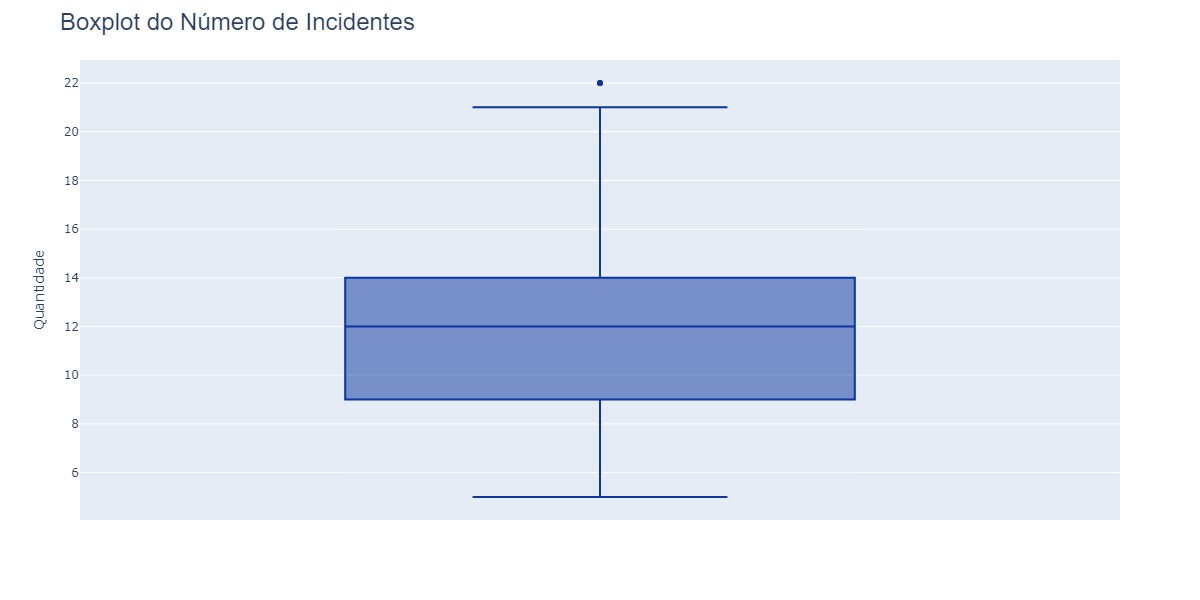

In [274]:
fig = px.box(
    incident_freq.df(),
    y='incidentCount',
    color_discrete_sequence=palette
)

fig.update_layout(
    title='Boxplot do Número de Incidentes',
    title_font={'family': 'Helvetica', 'size':24},
    yaxis_title='Quantidade',
    width=1200,
    height=600
)

fig.show(
    renderer='png'
)

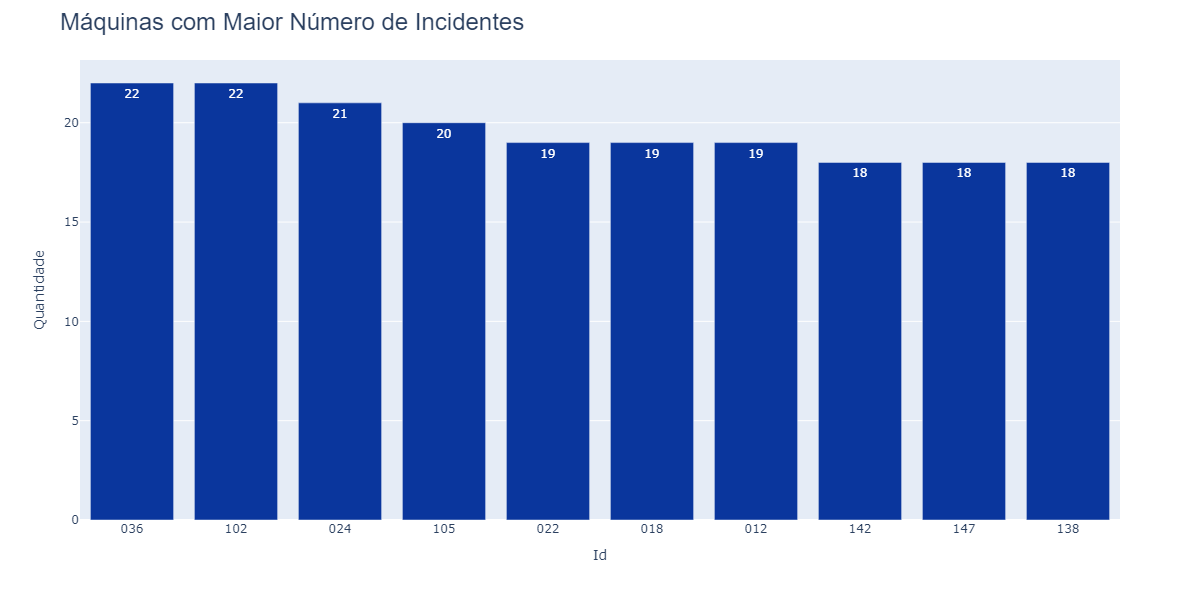

In [ ]:
fig = px.bar(
    x = df['machineId'].value_counts().index[:10],
    y = df['machineId'].value_counts().values[:10],
    text_auto=True,
    color_discrete_sequence=palette
)

fig.update_layout(
    title='Máquinas com Maior Número de Incidentes',
    title_font={'family': 'Helvetica', 'size': 24},
    xaxis_title='Id',
    yaxis_title='Quantidade',
    width=1200,
    height=600
)

fig.show(
    renderer='png'
)

In [288]:
duckdb.sql(
    """
    SELECT
        machineId,
        machineType,
        machineAge,
        SUM(downtimeHours) AS totalDowntime,
        SUM(maintenanceCost) AS totalCost
    FROM df
    WHERE machineId IN ('036', '102')
    GROUP BY machineId, machineType, machineAge
    """
)

┌───────────┬────────────────────────┬────────────┬───────────────┬────────────────────┐
│ machineId │      machineType       │ machineAge │ totalDowntime │     totalCost      │
│  varchar  │        varchar         │   int64    │    int128     │       double       │
├───────────┼────────────────────────┼────────────┼───────────────┼────────────────────┤
│ 102       │ Perfuratriz            │          4 │           744 │          263161.71 │
│ 036       │ Escavadeira Hidráulica │          9 │          1005 │ 331731.95000000007 │
└───────────┴────────────────────────┴────────────┴───────────────┴────────────────────┘

A máquina Id 102 é uma Perfuratriz relativamente nova, com apenas quatro anos de uso é necessária uma atenção especial com ela, seu custos de manutenção estão próximos ao da máquina Id 036 que tem 9 anos de uso. A máquina Id 036 é uma das máquinas mais antigas nas Astarte Co., se viável sua troca pode ser considerada. 

### `machineType`

In [ ]:
duckdb.sql(
    """
    SELECT 
        machineType,
        COUNT(incidentId) AS incidentCount
    FROM df
    GROUP BY machineType
    ORDER BY incidentCount DESC
    """
)

┌──────────────────────────┬───────────────┐
│       machineType        │ incidentCount │
│         varchar          │     int64     │
├──────────────────────────┼───────────────┤
│ Escavadeira Hidráulica   │           723 │
│ Caminhão Fora de Estrada │           473 │
│ Perfuratriz              │           277 │
│ Carregadeira             │           248 │
│ Britador Primário        │            79 │
└──────────────────────────┴───────────────┘

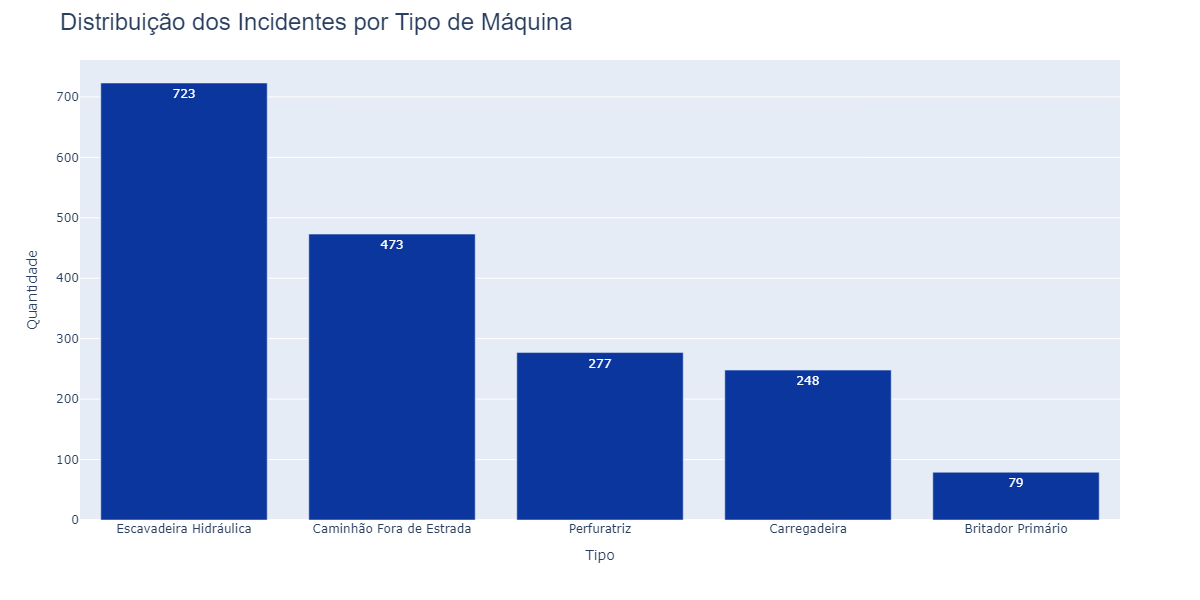

In [186]:
fig = px.bar(
    x = df['machineType'].value_counts().index,
    y = df['machineType'].value_counts().values,
    text_auto=True,
    color_discrete_sequence=palette
)

fig.update_layout(
    title='Distribuição dos Incidentes por Tipo de Máquina',
    title_font={'family': 'Helvetica', 'size': 24},
    xaxis_title='Tipo',
    yaxis_title='Quantidade',
    width=1200,
    height=600
)

fig.show(
    renderer='png'
)

As escavadeiras tem o maior número de incidentes, com uma diferença considerável quando comparada com o restante das máquinas.

### `incidentType`

In [217]:
duckdb.sql(
    """
    SELECT 
        incidentType,
        COUNT(incidentId) AS incidentCount
    FROM df
    GROUP BY incidentType
    ORDER BY incidentCount DESC
    """
)

┌─────────────────────────────────┬───────────────┐
│          incidentType           │ incidentCount │
│             varchar             │     int64     │
├─────────────────────────────────┼───────────────┤
│ Falha no sistema de rotação     │           196 │
│ Vazamento de óleo hidráulico    │           185 │
│ Desgaste dos dentes da caçamba  │           175 │
│ Quebra do cilindro hidráulico   │           167 │
│ Quebra do eixo traseiro         │           133 │
│ Vazamento de óleo do motor      │           133 │
│ Falha no sistema de transmissão │           115 │
│ Desgaste das pastilhas de freio │            92 │
│ Vazamento de combustível        │            81 │
│ Quebra do motor de perfuração   │            77 │
│ Danos na caçamba de carga       │            69 │
│ Desgaste dos pneus              │            64 │
│ Falha no compressor de ar       │            60 │
│ Superaquecimento do motor       │            59 │
│ Desgaste da broca               │            59 │
│ Falha no s

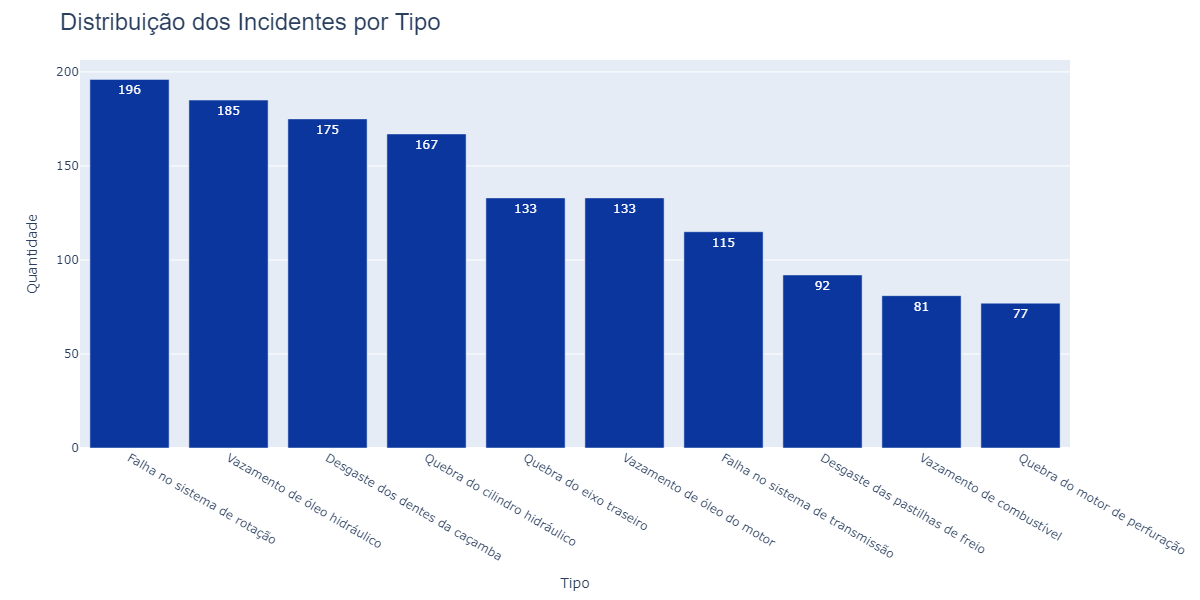

In [188]:
fig = px.bar(
    x = df['incidentType'].value_counts().index[:10],
    y = df['incidentType'].value_counts().values[:10],
    text_auto=True,
    color_discrete_sequence=palette
)

fig.update_layout(
    title='Distribuição dos Incidentes por Tipo',
    title_font={'family': 'Helvetica', 'size': 24},
    xaxis_title='Tipo',
    yaxis_title='Quantidade',
    width=1200,
    height=600
)

fig.show(
    renderer='png'
)

### `severity`

In [219]:
duckdb.sql(
    """
    SELECT 
        severity,
        COUNT(incidentId) AS incidentCount
    FROM df
    GROUP BY severity
    ORDER BY incidentCount DESC
    LIMIT 10
    """
)

┌──────────┬───────────────┐
│ severity │ incidentCount │
│ varchar  │     int64     │
├──────────┼───────────────┤
│ Média    │           478 │
│ Crítica  │           468 │
│ Alta     │           444 │
│ Baixa    │           410 │
└──────────┴───────────────┘

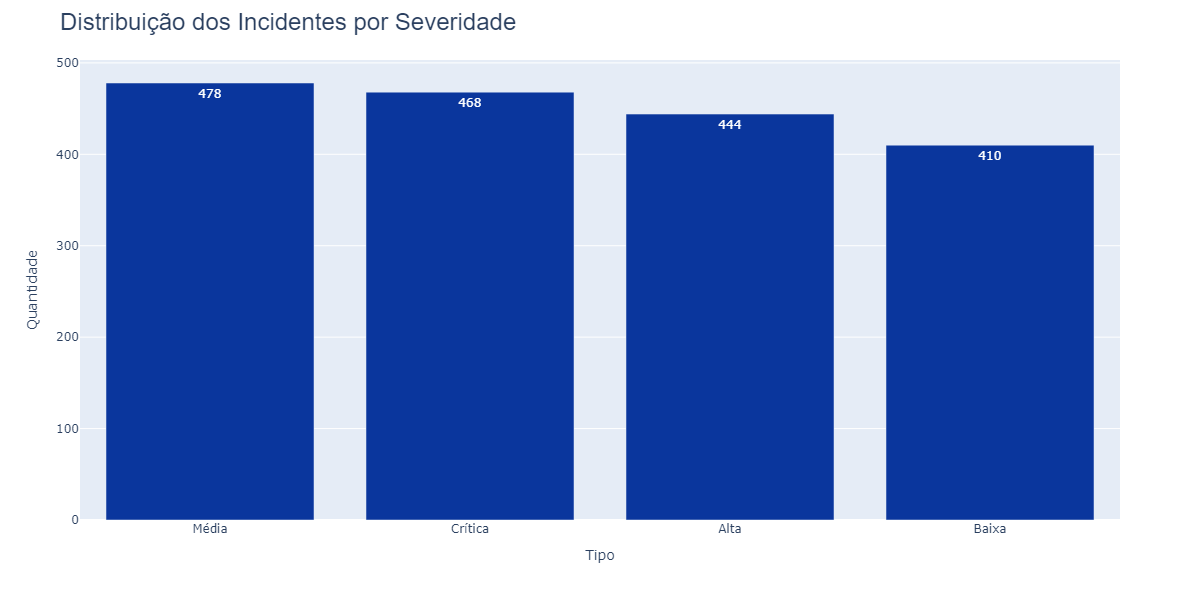

In [191]:
fig = px.bar(
    x = df['severity'].value_counts().index,
    y = df['severity'].value_counts().values,
    text_auto=True,
    color_discrete_sequence=palette
)

fig.update_layout(
    title='Distribuição dos Incidentes por Severidade',
    title_font={'family': 'Helvetica', 'size': 24},
    xaxis_title='Tipo',
    yaxis_title='Quantidade',
    width=1200,
    height=600
)

fig.show(
    renderer='png'
)

### `downtimeHours`

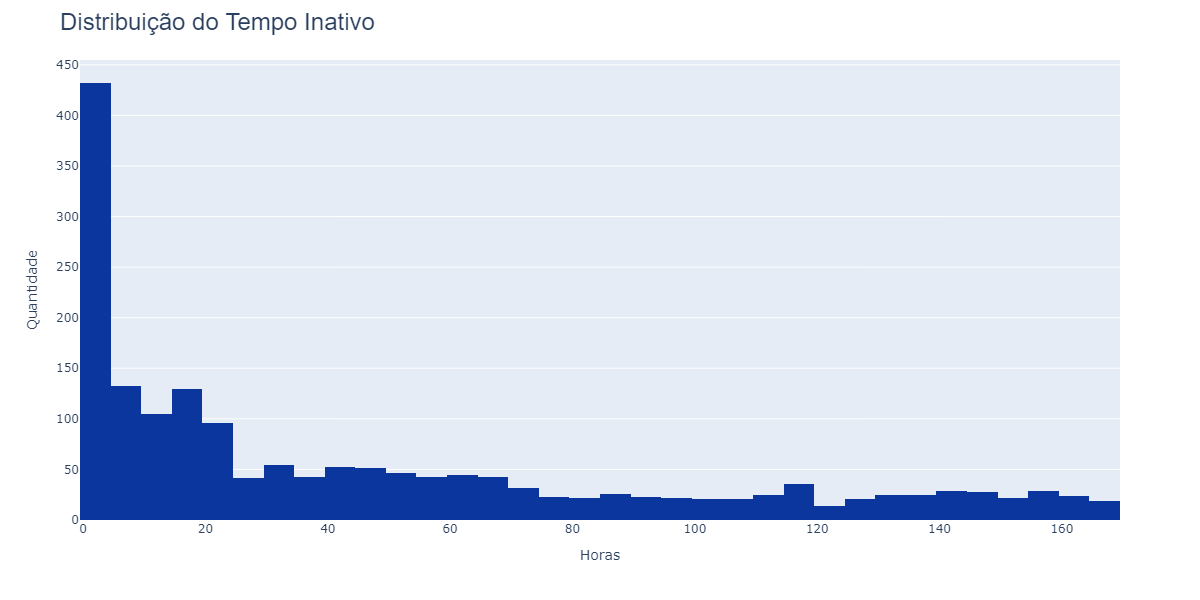

In [192]:
fig = px.histogram(
    df,
    x = 'downtimeHours',
    color_discrete_sequence=palette
)

fig.update_layout(
    title='Distribuição do Tempo Inativo',
    title_font={'family': 'Helvetica', 'size': 24},
    xaxis_title='Horas',
    yaxis_title='Quantidade',
    width=1200,
    height=600
)

fig.show(
    renderer='png'
)

Vamos plotar um boxplot para visualizar possíveis outliers.

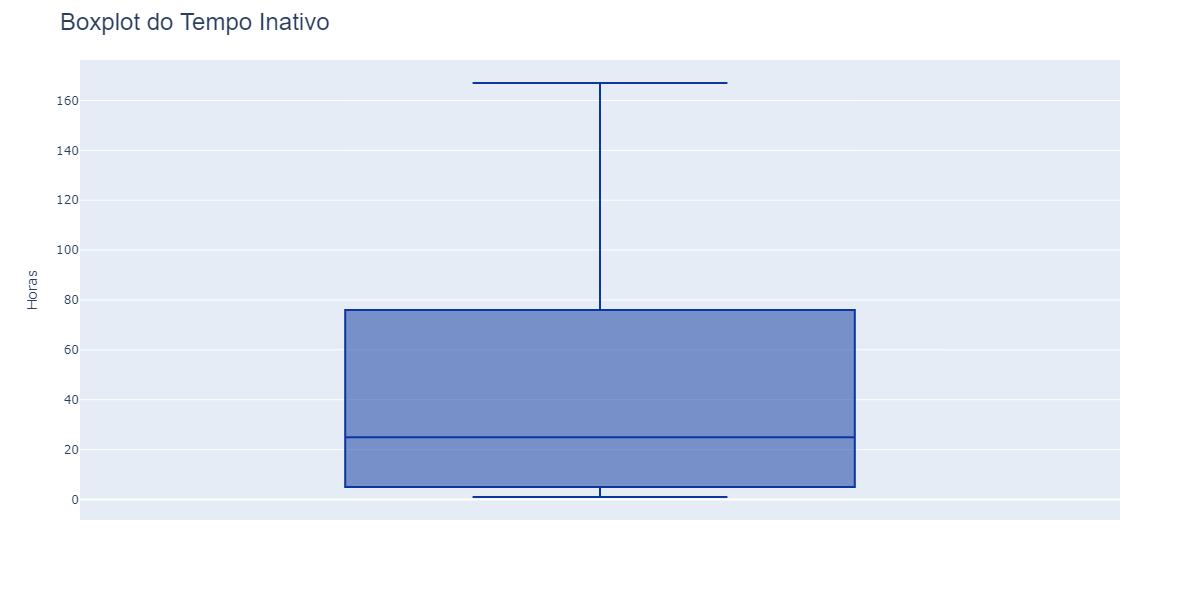

In [193]:
fig = px.box(
    df,
    y = 'downtimeHours',
    color_discrete_sequence=palette
)

fig.update_layout(
    title='Boxplot do Tempo Inativo',
    title_font={'family': 'Helvetica', 'size': 24},
    yaxis_title='Horas',
    width=1200,
    height=600
)

fig.show(
    renderer='png'
)

### `maintenanceCost`

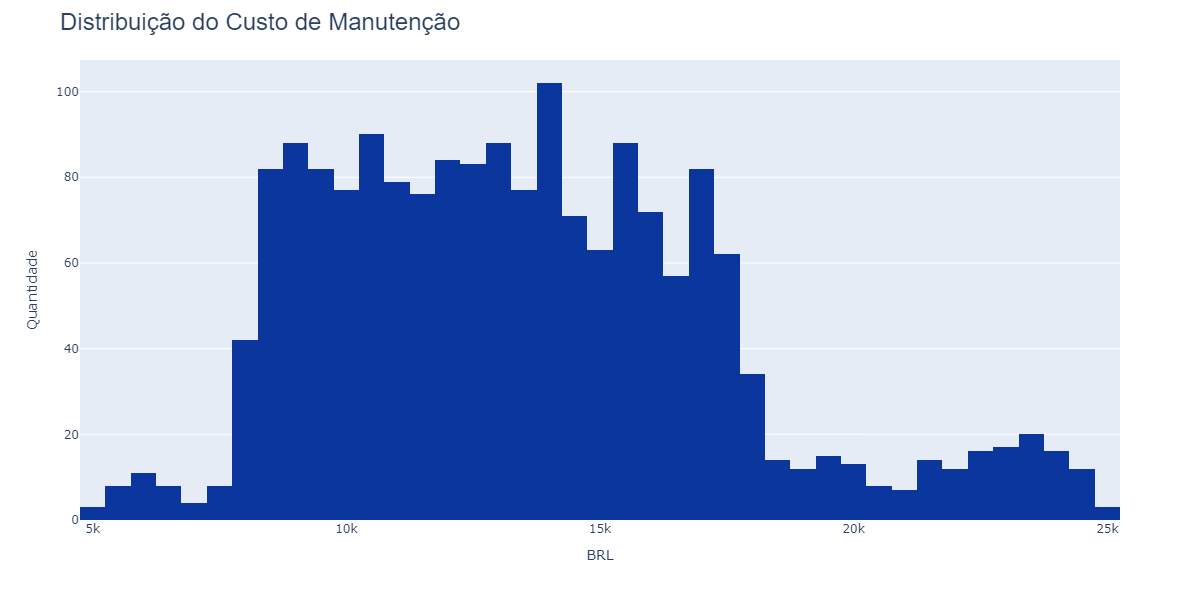

In [195]:
fig = px.histogram(
    df,
    x = 'maintenanceCost',
    color_discrete_sequence=palette
)

fig.update_layout(
    title='Distribuição do Custo de Manutenção',
    title_font={'family': 'Helvetica', 'size': 24},
    xaxis_title='BRL',
    yaxis_title='Quantidade',
    width=1200,
    height=600
)

fig.show(
    renderer='png'
)

Novamente um boxplot para visualizar possíveis outliers.

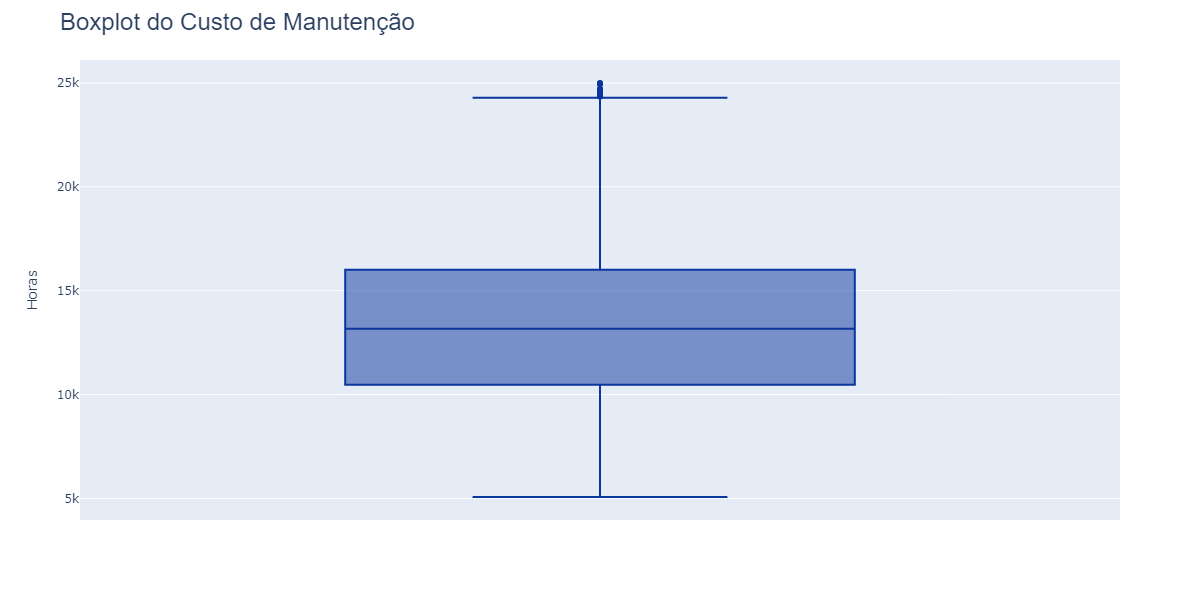

In [196]:
fig = px.box(
    df,
    y = 'maintenanceCost',
    color_discrete_sequence=palette
)

fig.update_layout(
    title='Boxplot do Custo de Manutenção',
    title_font={'family': 'Helvetica', 'size': 24},
    yaxis_title='Horas',
    width=1200,
    height=600
)

fig.show(
    renderer='png'
)

In [197]:
q1 = df['maintenanceCost'].quantile(0.25)
q3 = df['maintenanceCost'].quantile(0.75)

lower = q1 - 1.5 * (q3 - q1)
upper = q3 + 1.5 * (q3 - q1)

outliers = df[(df['maintenanceCost'] < lower) | (df['maintenanceCost'] > upper)]
outliers

,machineId,incidentId,purchaseDate,maintenanceDate,incidentDate,machineType,incidentType,severity,operationalCost,downtimeHours,maintenanceCost
29,084,038,2016-02-16,2024-08-31,2024-08-30,Carregadeira,Desgaste dos pneus,Baixa,500.0,3,24707.09
100,015,127,2018-12-16,2022-10-29,2022-10-28,Carregadeira,Desgaste dos pneus,Baixa,500.0,3,24999.31
109,034,138,2016-07-30,2023-08-22,2023-08-21,Carregadeira,Superaquecimento do motor,Alta,500.0,44,24396.93
185,007,225,2016-09-28,2020-05-27,2020-05-26,Carregadeira,Desgaste dos pneus,Baixa,500.0,3,24477.27
881,073,1108,2021-06-15,2023-05-26,2023-05-25,Carregadeira,Danos na caçamba de carga,Crítica,500.0,116,24650.31
1029,143,1305,2024-03-05,2024-06-19,2024-06-18,Carregadeira,Falha no sistema hidráulico,Média,500.0,13,24398.62
1111,034,1416,2016-07-30,2022-09-05,2022-09-04,Carregadeira,Danos na caçamba de carga,Crítica,500.0,119,24345.21
1173,012,1490,2015-07-05,2020-03-13,2020-03-12,Carregadeira,Falha no sistema hidráulico,Média,500.0,5,24957.75
1220,072,1548,2022-11-12,2024-11-17,2024-11-16,Carregadeira,Danos na caçamba de carga,Crítica,500.0,111,24718.26
1312,143,1674,2024-03-05,2024-12-27,2024-12-26,Carregadeira,Danos na caçamba de carga,Crítica,500.0,146,24970.58


Todos os outliers de `maintenanceCost` são de carregadeiras, é preciso investigar a razão disso junto aos responsáveis técnicos.

## Análises bivariadas

In [338]:
duckdb.sql(
    """
    SELECT
        machineType,
        COUNT(machineId) AS totalMachines,
        operationalCost
    FROM machines
    GROUP BY machineType, operationalCost
    ORDER BY totalMachines DESC
    """
)

┌──────────────────────────┬───────────────┬─────────────────┐
│       machineType        │ totalMachines │ operationalCost │
│         varchar          │     int64     │     double      │
├──────────────────────────┼───────────────┼─────────────────┤
│ Escavadeira Hidráulica   │            61 │           630.0 │
│ Caminhão Fora de Estrada │            38 │           640.0 │
│ Perfuratriz              │            23 │           420.0 │
│ Carregadeira             │            21 │           500.0 │
│ Britador Primário        │             7 │           300.0 │
└──────────────────────────┴───────────────┴─────────────────┘

In [222]:
duckdb.sql(
    """
    SELECT 
        machineType,
        SUM(downtimeHours) AS totalDowntime,
        AVG(downtimeHours) AS avgDowntime,
    FROM df
    GROUP BY machineType
    ORDER BY totalDowntime DESC
    """
)

┌──────────────────────────┬───────────────┬────────────────────┐
│       machineType        │ totalDowntime │    avgDowntime     │
│         varchar          │    int128     │       double       │
├──────────────────────────┼───────────────┼────────────────────┤
│ Escavadeira Hidráulica   │         33203 │ 45.923928077455045 │
│ Caminhão Fora de Estrada │         22731 │  48.05708245243129 │
│ Perfuratriz              │         13348 │ 48.187725631768956 │
│ Carregadeira             │         12061 │  48.63306451612903 │
│ Britador Primário        │          3631 │ 45.962025316455694 │
└──────────────────────────┴───────────────┴────────────────────┘

In [224]:
duckdb.sql(
    """
    SELECT 
        machineType,
        SUM(maintenanceCost) AS totalCost,
        AVG(maintenanceCost) AS avgCost,
    FROM df
    GROUP BY machineType
    ORDER BY totalCost DESC
    """
)

┌──────────────────────────┬────────────────────┬────────────────────┐
│       machineType        │     totalCost      │      avgCost       │
│         varchar          │       double       │       double       │
├──────────────────────────┼────────────────────┼────────────────────┤
│ Escavadeira Hidráulica   │ 10815295.290000008 │ 14958.914647302916 │
│ Carregadeira             │  5020191.850000001 │  20242.70907258065 │
│ Caminhão Fora de Estrada │ 4776200.6499999985 │ 10097.675792811837 │
│ Perfuratriz              │ 3186258.7199999993 │ 11502.739061371838 │
│ Britador Primário        │  596125.2499999999 │  7545.889240506328 │
└──────────────────────────┴────────────────────┴────────────────────┘

Novamente em relação aos custos, as carregadeiras chamam atenção, apesar de serem o quarto tipo de máquina com mais defeitos das cinco, elas representam o segundo maior custo nas manutenções. Os caminhões também merecem atenção por seu alto tempo de parada, e custos de manutenção. 

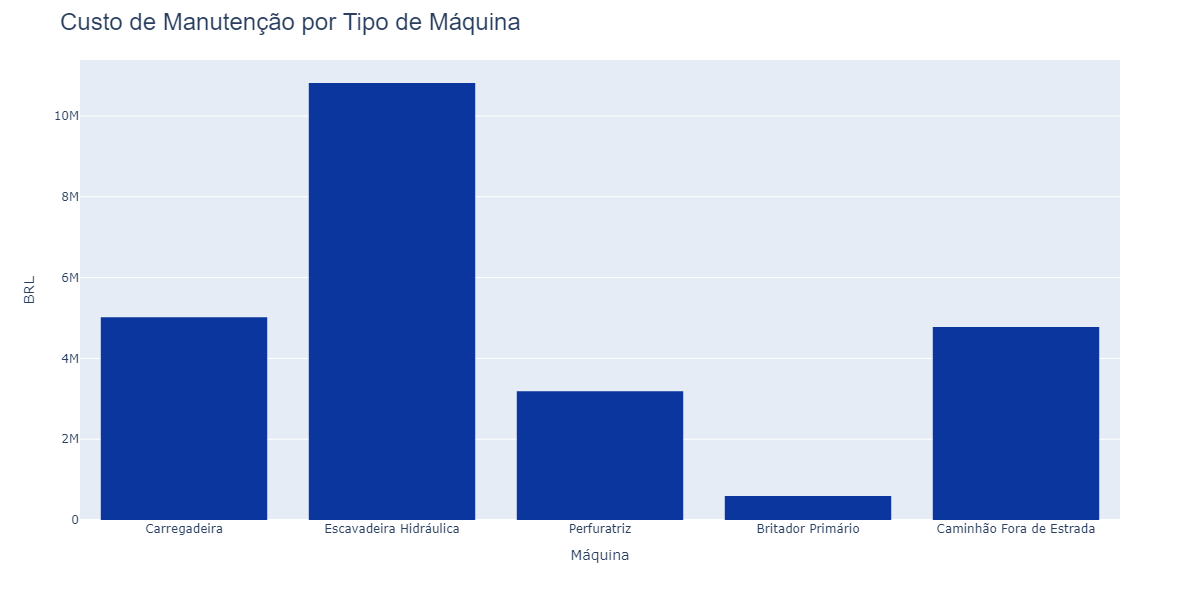

In [268]:
fig = px.histogram(
    df,
    x='machineType',
    y='maintenanceCost',
    color_discrete_sequence=palette
)

fig.update_layout(
    title='Custo de Manutenção por Tipo de Máquina',
    title_font={'family': 'Helvetica', 'size': 24},
    xaxis_title='Máquina',
    yaxis_title='BRL',
    width=1200,
    height=600
)

fig.show(
    renderer='png'
)

# Respondendo as perguntas
**Qual o tempo de inatividade das máquinas e sua taxa de disponibilidade?**

In [ ]:
availability = duckdb.sql(
    """
    WITH source AS (
        SELECT
            machineId,
            DATEDIFF('HOURS', purchaseDate, '2024-12-31') AS totalAvailabilityHours,
            SUM(downtimeHours) AS totalDowntime
        FROM df
        GROUP BY machineId, purchaseDate
        ORDER BY machineId
    )

    SELECT 
        *,
        ROUND((1 - (totalDowntime / totalAvailabilityHours)) * 100, 2) AS availabilityPerc
    FROM source
    """
).df()
availability.head()

,machineId,totalAvailabilityHours,totalDowntime,availabilityPerc
0,001,71064,423.0,99.40
1,002,83928,325.0,99.61
2,003,46656,395.0,99.15
3,004,51144,553.0,98.92
4,005,54384,439.0,99.19


In [325]:
print(f"O tempo de inatividade médio é {round(availability['totalDowntime'].mean(), 2)} horas.")
print(f"A taxa de disponibilidade média é {round((availability['availabilityPerc'].mean()),2)}%")

O tempo de inatividade médio é 566.49 horas.
A taxa de disponibilidade média é 96.56%


**Qual o custo de manutenção por tipo de máquina, e máquina individualmente?**

In [328]:
duckdb.sql(
    """
    SELECT
        machineId,
        machineType,
        ROUND(SUM(maintenanceCost), 2) AS totalCost
    FROM df
    GROUP BY machineId, machineType
    ORDER BY machineId 
    """
)

┌───────────┬──────────────────────────┬───────────┐
│ machineId │       machineType        │ totalCost │
│  varchar  │         varchar          │  double   │
├───────────┼──────────────────────────┼───────────┤
│ 001       │ Perfuratriz              │ 102354.01 │
│ 002       │ Escavadeira Hidráulica   │ 110511.28 │
│ 003       │ Caminhão Fora de Estrada │   83354.7 │
│ 004       │ Escavadeira Hidráulica   │ 159931.73 │
│ 005       │ Escavadeira Hidráulica   │ 166972.14 │
│ 006       │ Escavadeira Hidráulica   │  90259.15 │
│ 007       │ Carregadeira             │ 160034.96 │
│ 008       │ Carregadeira             │ 271620.23 │
│ 009       │ Perfuratriz              │ 120465.78 │
│ 010       │ Perfuratriz              │  95002.03 │
│  ·        │      ·                   │      ·    │
│  ·        │      ·                   │      ·    │
│  ·        │      ·                   │      ·    │
│ 141       │ Escavadeira Hidráulica   │  124563.6 │
│ 142       │ Perfuratriz              │ 20105

In [329]:
duckdb.sql(
    """
    SELECT
        machineType,
        ROUND(SUM(maintenanceCost), 2) AS totalCost
    FROM df
    GROUP BY machineType
    ORDER BY totalCost DESC
    """
)

┌──────────────────────────┬─────────────┐
│       machineType        │  totalCost  │
│         varchar          │   double    │
├──────────────────────────┼─────────────┤
│ Escavadeira Hidráulica   │ 10815295.29 │
│ Carregadeira             │  5020191.85 │
│ Caminhão Fora de Estrada │  4776200.65 │
│ Perfuratriz              │  3186258.72 │
│ Britador Primário        │   596125.25 │
└──────────────────────────┴─────────────┘

**Qual a quantidade de incidentes por tipo de máquina?**

In [330]:
duckdb.sql(
    """
    SELECT
        machineType,
        COUNT(incidentId) AS incidentCount
    FROM df
    GROUP BY machineType
    ORDER BY incidentCount DESC
    """
)

┌──────────────────────────┬───────────────┐
│       machineType        │ incidentCount │
│         varchar          │     int64     │
├──────────────────────────┼───────────────┤
│ Escavadeira Hidráulica   │           723 │
│ Caminhão Fora de Estrada │           473 │
│ Perfuratriz              │           277 │
│ Carregadeira             │           248 │
│ Britador Primário        │            79 │
└──────────────────────────┴───────────────┘

## Conclusões e recomendações

A Astarte Co. tem máquinas com uma boa taxa de disponibilidade em média (96,56%), um ponto de anteção são as Carregadeiras com um custo elevado de manutenções comparada as outras máquinas. Além disso é necessária uma atenção com os caminhões por seu alto tempo de indisponibilidade quando comparado com as outras máquinas, e também custos elevados. 

**Recomendações**
- Investigar causas mecânicas e humanas por trás do alto número de falhas nas máquinas Id 036 e 102. E em caso de orçamento livre, substituir a Id 036. 
- Investigar a operação dos caminhões, e revisar suas manutenções.
- Revisar e fiscalizar as manutenções das carregadeiras. 
- Incluir no registro de acidentes o Id do operador para identificação e monitoramento dos operadores.